In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
import pandas as pd
import numpy as np
import datetime
from pandas_summary import DataFrameSummary

In [3]:
df = pd.read_feather('train_normalized_data.fth')
df_test = pd.read_feather('test_normalized_data.fth')

In [4]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen', 'Promo2Weeks', 
            'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear', 'State', 
            'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw', 'SchoolHoliday_fw', 'SchoolHoliday_bw']

# cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'State']


In [5]:
contin_vars = ['CompetitionDistance', 
   'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']
# contin_vars = []

In [6]:
from lightgbm import LGBMRegressor

In [72]:
df_train = df[df.Date < datetime.datetime(2015, 7, 1)]  
df_val = df[df.Date >= datetime.datetime(2015, 7, 1)]
print(f'Cantidad en val: {len(df_val)}, porcentaje: {len(df_train)/(len(df_train) + len(df_val))}')

Cantidad en val: 30188, porcentaje: 0.9642465458145908


In [73]:
X_train = df_train[cat_vars + contin_vars]
X_val = df_val[cat_vars + contin_vars]

In [74]:
X_train.shape, X_val.shape

((814150, 38), (30188, 38))

In [75]:
y_train.shape, y_val.shape

((814150, 1), (30188, 1))

In [159]:
log_output = True
    
if log_output:
    # Escala logaritmica
    max_log_y = np.max(np.log(df[y_out_columns])).values
    y_train = np.log(df_train[y_out_columns].values)/max_log_y
    y_val = np.log(df_val[y_out_columns].values)/max_log_y
else:
    # Normalización
    y_mean = df_train[y_out_columns].mean().values
    y_std = df_train[y_out_columns].std().values
    y_train = (df_train[y_out_columns].values - y_mean)/y_std
    y_val = (df_val[y_out_columns].values - y_mean)/y_std

In [173]:
model = LGBMRegressor(min_child_samples=5, n_estimators=2000, learning_rate=0.05, )

In [174]:
fit_params={"early_stopping_rounds":100, 
            "eval_metric" : 'l2', 
            "eval_set" : [(X_val, y_val.reshape(-1))],
            'eval_names': ['valid'],
            'verbose': 100,
            'feature_name': 'auto', # that's actually the default
            'categorical_feature': cat_vars
           }

In [175]:
model.fit(X_train, y_train.reshape(-1), **fit_params)

Training until validation scores don't improve for 100 rounds.
[100]	valid's l2: 0.000221869	valid's l2: 0.000221869
[200]	valid's l2: 0.000170254	valid's l2: 0.000170254
[300]	valid's l2: 0.00014961	valid's l2: 0.00014961
[400]	valid's l2: 0.000139196	valid's l2: 0.000139196
[500]	valid's l2: 0.000134309	valid's l2: 0.000134309
[600]	valid's l2: 0.000128938	valid's l2: 0.000128938
[700]	valid's l2: 0.000126618	valid's l2: 0.000126618
[800]	valid's l2: 0.00012438	valid's l2: 0.00012438
[900]	valid's l2: 0.000122028	valid's l2: 0.000122028
[1000]	valid's l2: 0.000120219	valid's l2: 0.000120219
[1100]	valid's l2: 0.000119156	valid's l2: 0.000119156
[1200]	valid's l2: 0.000118039	valid's l2: 0.000118039
[1300]	valid's l2: 0.000117423	valid's l2: 0.000117423
[1400]	valid's l2: 0.000117173	valid's l2: 0.000117173
[1500]	valid's l2: 0.000116672	valid's l2: 0.000116672
[1600]	valid's l2: 0.000116112	valid's l2: 0.000116112
[1700]	valid's l2: 0.000116025	valid's l2: 0.000116025
[1800]	valid's 

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=-1,
              min_child_samples=5, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=2000, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

# Métrica

$$
\textrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{\hat{y}_i - y_i}{y_i}\right)^2}
$$

In [176]:
model.score(X_val, y_val)

0.9193009689720167

In [178]:
if log_output:
    y_pred_train = np.exp(model.predict(X_train, verbose=1)*max_log_y)
    y_pred = np.exp(model.predict(X_val, verbose=1)*max_log_y)
    # y_pred_test = np.exp(model.predict(X_test, verbose=1)*max_log_y)
else:
    y_pred_train = model.predict(X_train, verbose=1)*y_std + y_mean
    y_pred = model.predict(X_val, verbose=1)*y_std + y_mean
    # y_pred_test = model.predict(X_test, verbose=1)*y_std + y_mean

In [179]:
# Train
np.sqrt((((df_train['Sales'].values - y_pred_train)/df_train['Sales'].values)**2).sum()/len(y_pred_train))

0.08339404266578929

In [180]:
# Validación
np.sqrt((((df_val['Sales'].values - y_pred)/df_val['Sales'].values)**2).sum()/len(y_pred))

0.1189339574187933

# Baseline

In [28]:
import pandas as pd
sample_csv = pd.read_csv('dataset/rossmann/sample_submission.csv')

In [19]:
stores_mean = {}
for store, g_df in df.groupby('Store'):
    stores_mean[store] = g_df[g_df['Sales'] > 0]['Sales'].mean()

In [22]:
df_test['Sales'] = df_test['Store'].apply(stores_mean.get)
df_test.loc[df_test['Open'] == 0, 'Sales'] = 0

In [23]:
df_test[['Store', 'Sales']].head(10)

,Store,Sales
0,0,4759.096031
1,2,6942.568678
2,6,8817.050891
3,7,5539.358418
4,8,6562.337612
5,9,5568.420918
6,10,8030.977041
7,11,7589.598214
8,12,5034.747182
9,13,5508.567394


In [29]:
df_test[df_test['Open'] == 0][['Store', 'Sales']].head()

,Store,Sales
543,702,0.0
676,878,0.0
840,1096,0.0
1399,702,0.0
1532,878,0.0


In [32]:
sample_csv['Sales'] = df_test['Sales']

In [33]:
sample_csv.to_csv(f'submision_baseline.csv', index=False)

In [34]:
sample_csv.head()

,Id,Sales
0,1,4759.096031
1,2,6942.568678
2,3,8817.050891
3,4,5539.358418
4,5,6562.337612


# Sumbit a la competición

In [6]:

sample_csv = pd.read_csv('dataset/rossmann/sample_submission.csv')
sample_csv['Sales'] = y_pred_test
sample_csv.head()

sample_csv.to_csv(f'submision_{add_customers}-{log_output}-{output_activation}-{l2_lambda}-{first_hidden_units}-{epochs}-{batch_size}-{lr}.csv', index=False)


# Analisis de embedings

In [108]:
day_of_week_embedding = model.get_layer('DayOfWeek_Embed').get_weights()[0]

In [109]:
day_of_week_embedding.shape

(7, 4)

In [110]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

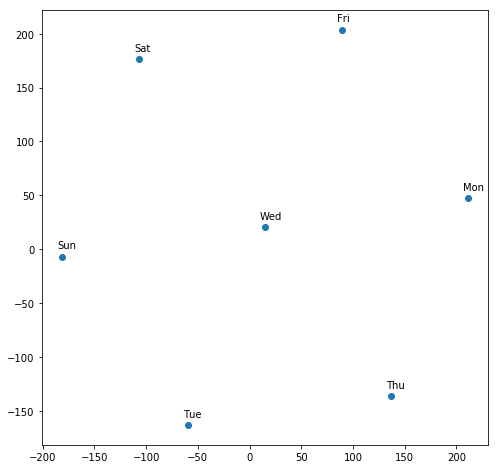

In [111]:
tsne = TSNE(init='pca', random_state=0, method='exact')
Y = tsne.fit_transform(day_of_week_embedding)
names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat','Sun']
plt.figure(figsize=(8,8))
plt.scatter(-Y[:, 0], -Y[:, 1])
for i, txt in enumerate(names):
    plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-5, 8), textcoords = 'offset points')